In [1]:
import astropy.coordinates as coord
import astropy.units as u
import matplotlib as mpl
import matplotlib.pyplot as plt
%matplotlib inline
import numpy as np

# gala
import gala.coordinates as gc
import gala.dynamics as gd
import gala.potential as gp
import gala.integrate as gi
from gala.units import galactic
from gala.dynamics.actionangle.tests.staeckel_helpers import galpy_find_actions_staeckel

import jax
jax.config.update('jax_enable_x64', True)
import jax.numpy as jnp

from empaf import VerticalOrbitModel

In [2]:
import sys
sys.path.append('/Users/apricewhelan/projects/others/Agama-zone')
import agama
agama.setUnits(mass=u.Msun, length=u.kpc, time=u.Myr)

In [3]:
gala_pot = gp.MilkyWayPotential()
agama_pot = agama.Potential(
    dict(type='miyamotonagai', mass=6.8e10, scaleradius=3.0, scaleheight=0.28),
    dict(type='dehnen', mass=5.00e9, scaleradius=1.0),
    dict(type='dehnen', mass=1.71e9, scaleradius=0.07),
    dict(type='nfw',    mass=5.4e11, scaleradius=15.62),
)

In [4]:
def get_random_z_vz(Jzs, Jphi=None, rng=None):
    in_shape = Jzs.shape
    Jzs = np.atleast_1d(Jzs)
    
    if rng is None:
        rng = np.random.default_rng()
        
    if Jphi is None:
        Jphi = 220 * u.km / u.s * 8 * u.kpc
        
    JR = 0 * u.km / u.s * u.kpc
    
    thzs = rng.uniform(0, 2*np.pi, size=len(Jzs))
    xvs = []
    for Jz, thz in zip(Jzs, thzs):
        act = u.Quantity([JR, Jz, Jphi]).to_value(u.kpc**2 / u.Myr)
        torus_mapper = agama.ActionMapper(agama_pot, act)
        ang = [0., thz, 0.]
        xv_torus = torus_mapper(ang)
        xvs.append(xv_torus)
    xvs = np.array(xvs)
    
    return xvs[:, [2, 5]].reshape(in_shape + (2, ))

In [45]:
zvz_batches = np.row_stack([np.random.uniform(size=(100, 6)) for i in range(8)])
zvz_batches.shape

(800, 6)

In [21]:
Jz_scale = 15*u.km/u.s * 0.25*u.kpc

rng = np.random.default_rng(42)
Jzs = (rng.exponential(scale=1., size=1000) + 1e-3) * Jz_scale
zvz = get_random_z_vz(Jzs, rng=rng)

(-2.0, 2.0)

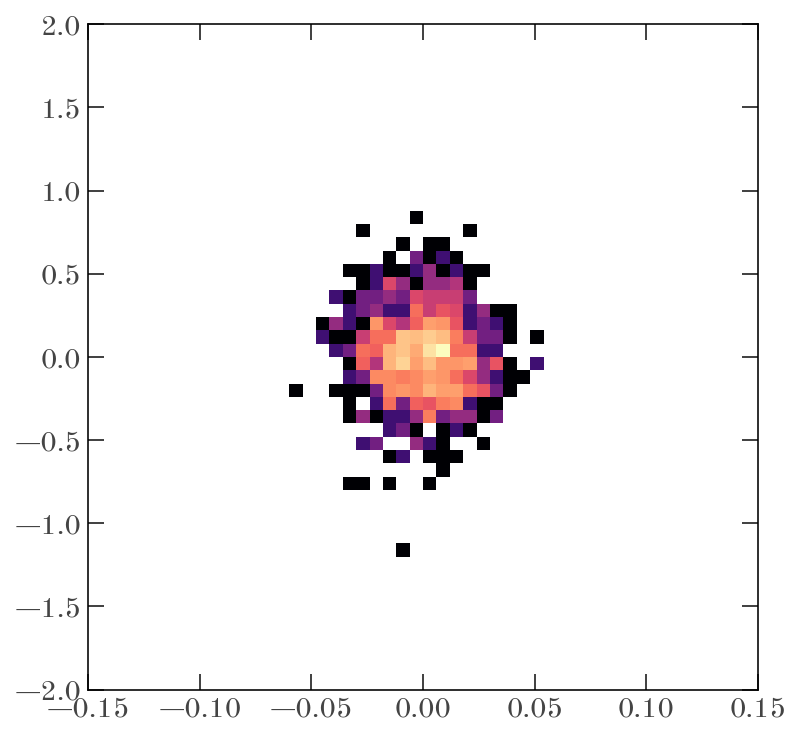

In [22]:
plt.hist2d(
    zvz[:, 1],
    zvz[:, 0],
    bins=(np.linspace(-0.15, 0.15, 51), np.linspace(-2, 2, 51)),
    norm=mpl.colors.LogNorm(),
)
plt.xlim(-0.15, 0.15)
plt.ylim(-2, 2)

array([[ 4.50322551e-03, -6.73367517e-04],
       [ 3.26349250e-03, -4.35452542e-03],
       [ 1.71278777e-01, -1.62033879e-04]])

In [123]:
# Jr, Jz, Jphi
# act = [0.031, 0.0017, 1.6]
act = u.Quantity([0 * u.km / u.s * u.kpc, Jz[0], Jphi_sun]).to_value(u.kpc**2 / u.Myr)
print(act)

torus_mapper = agama.ActionMapper(
    agama_pot, act
)  # J,theta -> x,v (Torus), with the given actions
# action_finder = agama.ActionFinder(agama_pot)      # x,v -> J,theta (Staeckel fudge)

Omega = np.array([torus_mapper.Omegar, torus_mapper.Omegaz, torus_mapper.Omegaphi])
print(Omega)

[0.         0.00194774 1.79997341]
[0.04306284 0.0756992  0.03144153]


In [ ]:
t_grid = np.linspace(0, 2*np.pi / Omega[1], 1000)

In [115]:
rng = np.random.default_rng(42)
# random_t = rng.uniform(0, 10_000, size=1000)
# random_t = np.arange(0, 10000, 1.)

angles = Omega[None] * random_t[:, None]
xv_torus = torus_mapper(angles)

[Text(0.5, 0, '$x$'), Text(0, 0.5, '$y$')]

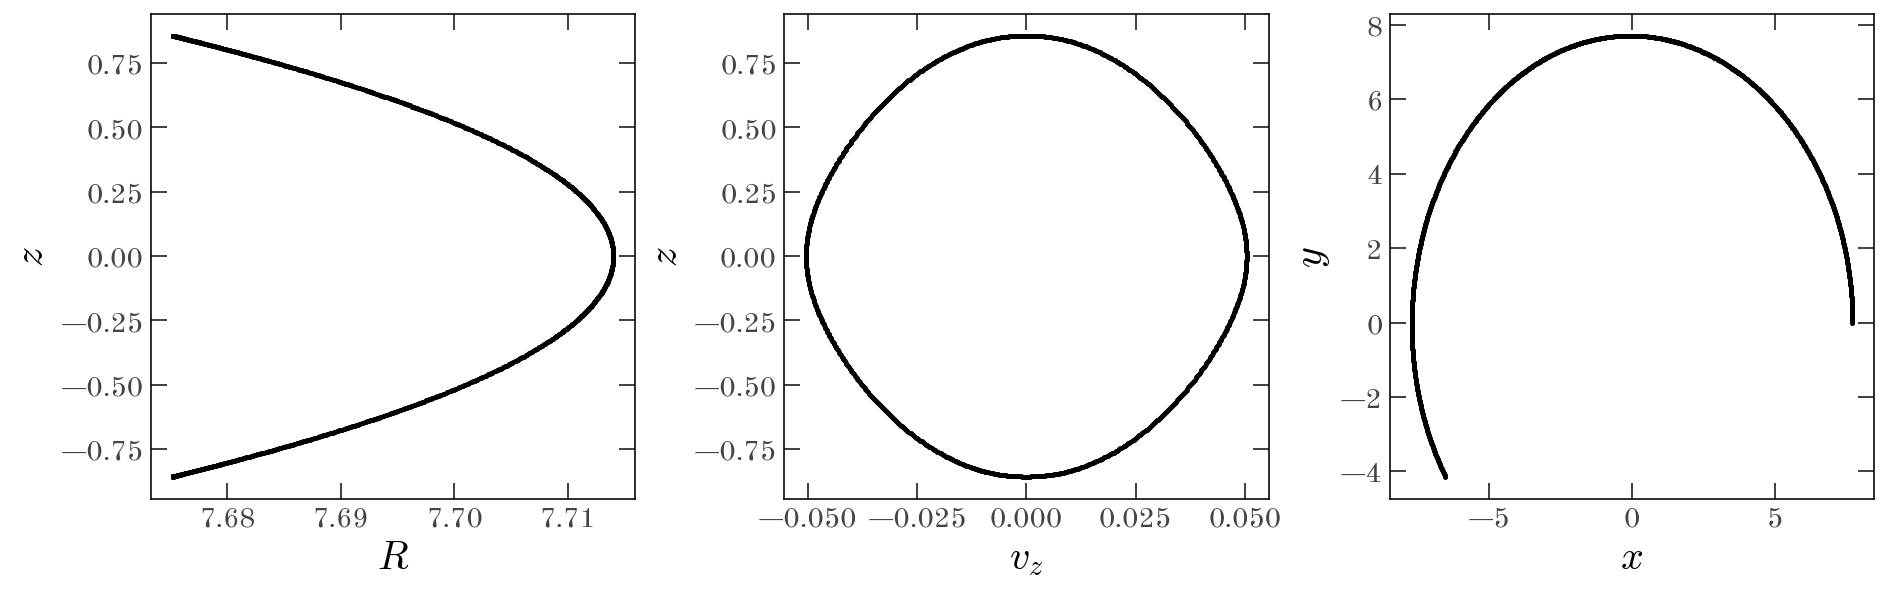

In [114]:
R = np.sqrt(xv_torus[:, 0]**2 + xv_torus[:, 1]**2)

fig, axes = plt.subplots(1, 3, figsize=(13, 4), constrained_layout=True)
axes[0].plot(R, xv_torus[:, 2], ls='none')
axes[0].set(xlabel='$R$', ylabel='$z$')
axes[1].plot(xv_torus[:, 2+3], xv_torus[:, 2], ls='none')
axes[1].set(xlabel='$v_z$', ylabel='$z$')
axes[2].plot(xv_torus[:, 0], xv_torus[:, 1], ls='none')
axes[2].set(xlabel='$x$', ylabel='$y$')

# Make fake data

In [10]:
pot = gp.load('../../gaia-actions/potentials/MilkyWayPotential2022.yml')

In [51]:
xyz = [8.275, 0, 1e-5] * u.kpc
vc = pot.circular_velocity(xyz)[0]
vxyz = [0, vc.value * 0.99925, 20] * vc.unit

w0 = gd.PhaseSpacePosition(xyz, vxyz)

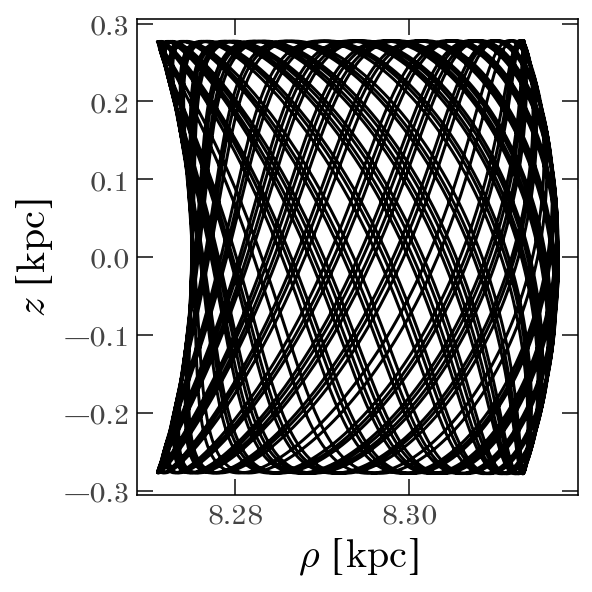

In [52]:
orbit = pot.integrate_orbit(
    w0, dt=0.5, n_steps=10000, Integrator=gi.Ruth4Integrator
)
_ = orbit.cylindrical.plot(['rho', 'z'])

In [53]:
galpy_find_actions_staeckel(pot, w0)

actions,freqs,angles
km kpc / s,km / (kpc s),rad
float64[3],float64[3],float64[3]
0.006753133129616998 .. 2.6920799470074543,38.06704479353414 .. 68.12448484394544,1.9723039867969305e-09 .. 3.418076471284337e-05


In [6]:
init_model = VerticalOrbitModel(
    dens_knots=jnp.linspace(0, np.sqrt(1.5), 8)**2,
    e_knots={
        2: jnp.array([0., 1.]),
        4: jnp.array([0., 1.]),
#         6: jnp.array([0., 1.]),
    },
    unit_sys=galactic
)